# 1. Импорт библиотек и загрузка данных

В этом разделе производится загрузка датасета, и импортируются нужные библиотеки

In [3]:
%%capture
import datasets
import matplotlib.pyplot as plt
from collections import Counter
import nltk
from nltk.tokenize import word_tokenize
nltk.download('punkt')
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import torch
import numpy as np
import re
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator, Vocab
from torch.utils.data import DataLoader, Dataset
import torch.nn as nn
import torch.optim as optim

# Настройка для воспроизводимости
torch.manual_seed(42)
np.random.seed(42)

# Настройка matplotlib
plt.rcParams['font.family'] = 'DejaVu Sans'
plt.style.use('seaborn-v0_8')

In [4]:
dataset = datasets.load_dataset("mxlcw/telegram-financial-sentiment-summarization", split='train')

dataset.shape

README.md:   0%|          | 0.00/175 [00:00<?, ?B/s]

telegram_data.csv:   0%|          | 0.00/27.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/18107 [00:00<?, ? examples/s]

(18107, 8)

In [5]:
data = dataset.to_pandas()

data['label'] = data['regular_text_sentiment_label'].map({'negative': 0, 'neutral': 1, 'positive' : 2})
data.head(), data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 18107 entries, 0 to 18106
Data columns (total 9 columns):
 #   Column                           Non-Null Count  Dtype  
---  ------                           --------------  -----  
 0   date                             18107 non-null  object 
 1   post_url                         18107 non-null  object 
 2   text                             18107 non-null  object 
 3   summarized_text                  18107 non-null  object 
 4   regular_text_sentiment_label     18107 non-null  object 
 5   regular_text_sentiment_score     18107 non-null  float64
 6   summarized_text_sentiment_label  18107 non-null  object 
 7   summarized_text_sentiment_score  18107 non-null  float64
 8   label                            18107 non-null  int64  
dtypes: float64(2), int64(1), object(6)
memory usage: 1.2+ MB


(                  date                                           post_url  \
 0  2023-01-10 16:19:00  https://t.me/tinkoff_analytics_official/483/?e...   
 1  2023-01-11 15:04:00  https://t.me/tinkoff_analytics_official/484/?e...   
 2  2023-01-12 18:13:00  https://t.me/tinkoff_analytics_official/485/?e...   
 3  2023-01-16 17:16:00  https://t.me/tinkoff_analytics_official/486/?e...   
 4  2023-01-17 17:25:00  https://t.me/tinkoff_analytics_official/489/?e...   
 
                                                 text  \
 0  ​​Спрос на морские перевозки падает — как это ...   
 1  Новое бюджетное правило в действии  \nС 13 янв...   
 2  Ожидаемое замедление инфляции в США   \nВ дека...   
 3  Главными событиями прошлой недели стали возвра...   
 4  ​​Сбер: рост прибыли ускоряется  \nрекомендаци...   
 
                                      summarized_text  \
 0  Спрос на морские перевозки из Азии в США упал ...   
 1  Банк России возобновит операции с иностранной ...   
 2  Ожидаемое з

# 2. Анализ категорий и структуры данных

Посмотрим как классы распределены, анализа будет не много, так как датасет не менялся с прошлой работы

Категории: ['negative' 'neutral' 'positive']
Количество категорий: 3
Распределение по категориям:
regular_text_sentiment_label
positive    7876
neutral     7337
negative    2894
Name: count, dtype: int64


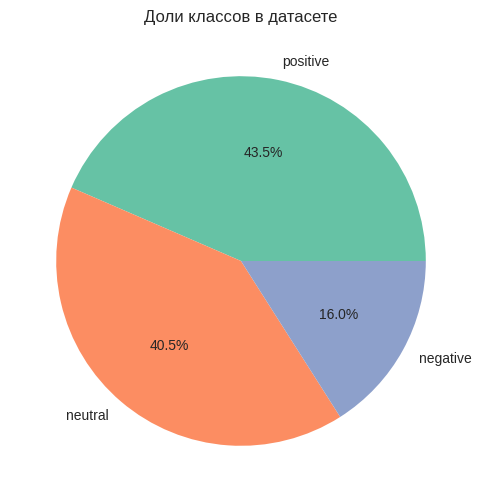

In [6]:
# Сколько и каких категорий есть в наборе
labels = data['regular_text_sentiment_label']
print('Категории:', labels.unique())
print('Количество категорий:', labels.nunique())
print('Распределение по категориям:')
print(labels.value_counts())

stats = labels.value_counts().reset_index()
stats.columns = ['Категория', 'Количество']
plt.figure(figsize=(6,6))
plt.pie(stats['Количество'], labels=stats['Категория'], autopct='%1.1f%%', colors=plt.cm.Set2.colors)
plt.title('Доли классов в датасете')
plt.show()

Предобработаем текста, чтобы посмотреть на слова, на длину предложений

In [7]:
# Анализ длины текстов
def clean_text(text):
    """Очистка текста от лишних символов"""
    if pd.isna(text):
        return ""

    # Удаляем лишние пробелы
    text = re.sub(r'\s+', ' ', text)

    # Удаляем специальные символы, оставляем только латиницу, кириллицу, цифры и пробелы
    text = re.sub(r'[^a-zA-Z0-9а-яА-ЯёЁ\s]', ' ', text)

    return text.strip().lower()

data['text_clean'] = data['text'].apply(clean_text)
data['text_len'] = data['text_clean'].str.len()


tokenizer = get_tokenizer('basic_english')
texts = data['text_clean'].astype(str).tolist()

# Токенизация
tokenized_texts = [tokenizer(text) for text in texts]
num_words = [len(tokens) for tokens in tokenized_texts]
num_unique_words = [len(set(tokens)) for tokens in tokenized_texts]
avg_words = np.mean(num_words)
avg_unique_words = np.mean(num_unique_words)

total_words = int(sum(num_words))

unique_tokens = set()
for tokens in tokenized_texts:
    unique_tokens.update(tokens)
total_unique = len(unique_tokens)


print("\nСтатистика по длине текстов:")
print(f"Средняя длина текста: {data['text_len'].mean():.1f} символов")
print(f'Среднее число слов в сообщении: {avg_words:.2f}')
print(f'Среднее число уникальных слов в сообщении: {avg_unique_words:.2f}')
print(f'Максимальная длина сообщения: {np.max(num_words)}')
print(f'Медианная длина сообщения: {np.median(num_words)}')
print(f"Общее число слов в датасете: {total_words}")
print(f"Количество уникальных токенов: {total_unique}")


Статистика по длине текстов:
Средняя длина текста: 551.4 символов
Среднее число слов в сообщении: 80.63
Среднее число уникальных слов в сообщении: 61.13
Максимальная длина сообщения: 633
Медианная длина сообщения: 39.0
Общее число слов в датасете: 1459979
Количество уникальных токенов: 58743


Решил создать словарь размером в 50000 символов, как будто бы должно убраться лишнее слова, в это 8 тыс. попадут слова которые редко встречались в корпусе.

In [8]:
# Создание словаря
def yield_tokens(data_iter):
    for tokens in tokenized_texts:
        yield tokens

# Ограничим размер словаря 
vocab_size = 50000
vocab = build_vocab_from_iterator(yield_tokens(tokenized_texts), specials=["<unk>", "<pad>"], max_tokens=vocab_size)
vocab.set_default_index(vocab["<unk>"])

Хотелось глянуть на распределение слов/симолов в преложениях и в классах

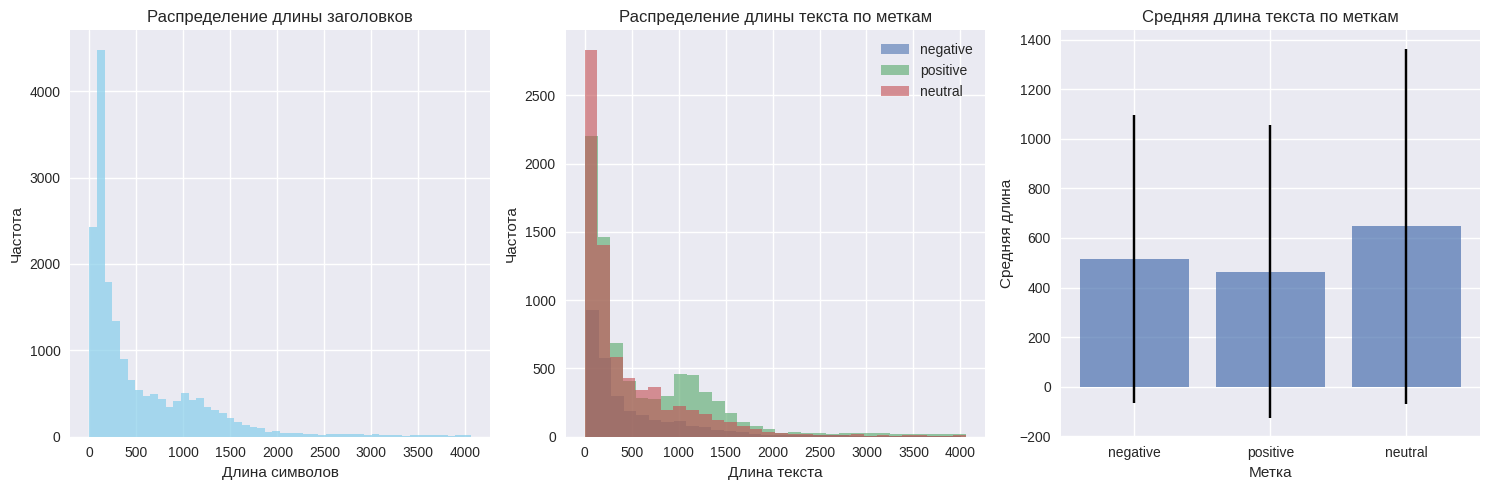

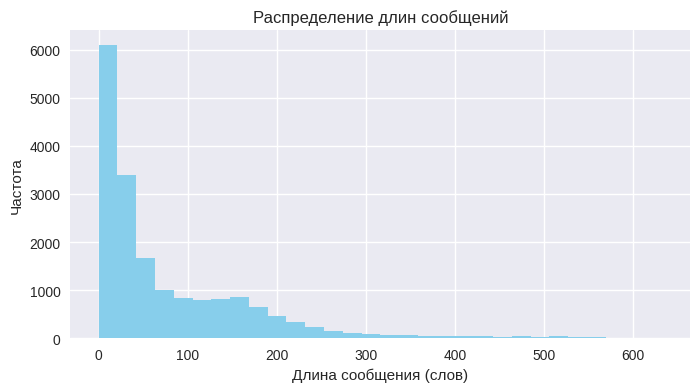

In [9]:
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.hist(data['text_len'], bins=50, alpha=0.7, color='skyblue')
plt.title('Распределение длины заголовков')
plt.xlabel('Длина символов')
plt.ylabel('Частота')

plt.subplot(1, 3, 2)
for label in ['negative', 'positive', 'neutral']:
    subset = data[data['regular_text_sentiment_label'] == label]
    plt.hist(subset['text_len'], bins=30, alpha=0.6, label=label)
plt.title('Распределение длины текста по меткам')
plt.xlabel('Длина текста')
plt.ylabel('Частота')
plt.legend()

plt.subplot(1, 3, 3)
label_length_stats = data.groupby('regular_text_sentiment_label')['text_len'].agg(['mean', 'median', 'std'])
plt.bar(label_length_stats.index, label_length_stats['mean'],
        yerr=label_length_stats['std'], capsize=5, alpha=0.7)
plt.title('Средняя длина текста по меткам')
plt.xlabel('Метка')
plt.ylabel('Средняя длина')
plt.xticks([0, 1, 2], ['negative', 'positive', 'neutral'])

plt.tight_layout()
plt.show()

# Гистограмма длин сообщений
plt.figure(figsize=(8,4))
plt.hist(num_words, bins=30, color='skyblue')
plt.xlabel('Длина сообщения (слов)')
plt.ylabel('Частота')
plt.title('Распределение длин сообщений')
plt.show()


# 3. Формирование датасета

Порежем датасет на под выборки, напишем класс для датасета. Создадим загрузчики

In [10]:
# Разделение датафрейма на train / val / test (пример: 70% / 15% / 15%)
# Используется стратификация по колонке 'regular_text_sentiment_label' для сохранения распределения классов
test_size = 0.15
val_size = 0.15

train_val_df, test_df = train_test_split(
    data,
    test_size=test_size,
    stratify=data['regular_text_sentiment_label'],
    random_state=42
)

val_relative = val_size / (1 - test_size)  # 0.15 / 0.85

train_df, val_df = train_test_split(
    train_val_df,
    test_size=val_relative,
    stratify=train_val_df['regular_text_sentiment_label'],
    random_state=42
)

train_df = train_df.reset_index(drop=True)
val_df = val_df.reset_index(drop=True)
test_df = test_df.reset_index(drop=True)

In [11]:
# Функция для токенизации и векторизации
def text_pipeline(text):
    return vocab(tokenizer(text))

# Функция для создания батчей
def collate_batch(batch):
    label_list, text_list, lengths = [], [], []
    for (_label, _text) in batch:
        label_list.append(_label)
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.int64)
        text_list.append(processed_text)
        # Защита от пустых последовательностей - минимальная длина 1
        lengths.append(max(len(processed_text), 1))

    label_list = torch.tensor(label_list, dtype=torch.int64)
    lengths = torch.tensor(lengths, dtype=torch.int64)
    text_list = torch.nn.utils.rnn.pad_sequence(text_list, batch_first=True, padding_value=vocab['<pad>'])

    return text_list, label_list, lengths

In [12]:
# Создание датасетов
class TelegramNewsDataset(Dataset):
    def __init__(self, dataframe):
        self.data = dataframe

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        return self.data.iloc[idx]['label'], self.data.iloc[idx]['text_clean']

# Создание датасетов
train_dataset = TelegramNewsDataset(train_df)
val_dataset = TelegramNewsDataset(val_df)
test_dataset = TelegramNewsDataset(test_df)

# Создание DataLoader'ов
BATCH_SIZE = 32
train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, collate_fn=collate_batch)

print(f"Размеры датасетов:")
print(f"Обучающий: {len(train_dataset)} примеров")
print(f"Валидационный: {len(val_dataset)} примеров")
print(f"Тестовый: {len(test_dataset)} примеров")
print(f"Размер батча: {BATCH_SIZE}")

Размеры датасетов:
Обучающий: 12674 примеров
Валидационный: 2716 примеров
Тестовый: 2717 примеров
Размер батча: 32


# 4. Первая модель, но зато какая. Baseline RNN

In [13]:
class RNNModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(RNNModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
        self.rnn = nn.RNN(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim, num_classes)

    def forward(self, text, lengths):
        # Embedding
        embedded = self.embedding(text)

        # Pack padded sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # RNN
        output, hidden = self.rnn(packed)

        # Unpack sequence
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)

        # Get the last output for each sequence
        batch_size = output.size(0)
        # Исправляем индексирование - lengths должен быть на CPU и в виде списка
        lengths_cpu = (lengths - 1).clamp(min=0).cpu().tolist()  # clamp для защиты от нулевых длин
        last_output = output[range(batch_size), lengths_cpu]

        # Apply dropout and classification
        output = self.dropout(last_output)
        output = self.fc(output)

        return output

# Параметры модели
VOCAB_SIZE = len(vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 3
NUM_LAYERS = 2
DROPOUT = 0.3

# Создание RNN модели
rnn_model = RNNModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASSES, NUM_LAYERS, DROPOUT)

print(f"RNN модель создана:")
print(f"Размер словаря: {VOCAB_SIZE}")
print(f"Размерность эмбеддингов: {EMBED_DIM}")
print(f"Размерность скрытого слоя: {HIDDEN_DIM}")
print(f"Количество классов: {NUM_CLASSES}")
print(f"Количество слоев: {NUM_LAYERS}")

# Подсчет параметров
total_params = sum(p.numel() for p in rnn_model.parameters())
trainable_params = sum(p.numel() for p in rnn_model.parameters() if p.requires_grad)
print(f"\nОбщее количество параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")


RNN модель создана:
Размер словаря: 50000
Размерность эмбеддингов: 128
Размерность скрытого слоя: 256
Количество классов: 3
Количество слоев: 2

Общее количество параметров: 6,631,171
Обучаемых параметров: 6,631,171


# 5. Функции обучения и оценки

Функции для обучения моделей и получения предсказаний.

In [ ]:
def train_model(model, train_loader, val_loader, num_epochs=10, learning_rate=0.001):
    """Функция для обучения модели"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=learning_rate)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=3, gamma=0.5)

    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    print(f"Обучение на устройстве: {device}")
    print(f"Количество эпох: {num_epochs}")
    print(f"Скорость обучения: {learning_rate}")

    for epoch in range(num_epochs):
        # Обучение
        model.train()
        train_loss = 0.0
        train_correct = 0
        train_total = 0

        for batch_idx, (text, labels, lengths) in enumerate(train_loader):
            text, labels, lengths = text.to(device), labels.to(device), lengths.to(device)

            optimizer.zero_grad()
            outputs = model(text, lengths)
            loss = criterion(outputs, labels)
            loss.backward()
            # Gradient clipping для предотвращения взрывающихся градиентов
            torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            train_total += labels.size(0)
            train_correct += (predicted == labels).sum().item()

            if batch_idx % 100 == 0:
                print(f'Эпоха {epoch+1}/{num_epochs}, Батч {batch_idx}/{len(train_loader)}, Loss: {loss.item():.4f}')

        # Валидация
        model.eval()
        val_loss = 0.0
        val_correct = 0
        val_total = 0

        with torch.no_grad():
            for text, labels, lengths in val_loader:
                text, labels, lengths = text.to(device), labels.to(device), lengths.to(device)
                outputs = model(text, lengths)
                loss = criterion(outputs, labels)

                val_loss += loss.item()
                _, predicted = torch.max(outputs.data, 1)
                val_total += labels.size(0)
                val_correct += (predicted == labels).sum().item()

        # Сохранение метрик
        avg_train_loss = train_loss / len(train_loader)
        avg_val_loss = val_loss / len(val_loader)
        train_acc = 100 * train_correct / train_total
        val_acc = 100 * val_correct / val_total

        train_losses.append(avg_train_loss)
        val_losses.append(avg_val_loss)
        train_accuracies.append(train_acc)
        val_accuracies.append(val_acc)

        print(f'Эпоха {epoch+1}/{num_epochs}:')
        print(f'  Train Loss: {avg_train_loss:.4f}, Train Acc: {train_acc:.2f}%')
        print(f'  Val Loss: {avg_val_loss:.4f}, Val Acc: {val_acc:.2f}%')
        print('-' * 50)

        scheduler.step()

    return train_losses, val_losses, train_accuracies, val_accuracies

def evaluate_model(model, test_loader):
    """Функция для оценки модели на тестовых данных"""
    device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
    model = model.to(device)
    model.eval()

    all_predictions = []
    all_labels = []

    with torch.no_grad():
        for text, labels, lengths in test_loader:
            text, labels, lengths = text.to(device), labels.to(device), lengths.to(device)
            outputs = model(text, lengths)
            _, predicted = torch.max(outputs.data, 1)

            all_predictions.extend(predicted.cpu().tolist())
            all_labels.extend(labels.cpu().tolist())

    return all_predictions, all_labels

Функции для обучения и оценки созданы!


# 6. Обучение RNN

Запуск обучения RNN и вывод метрик.

In [15]:
print("Начинаем обучение RNN модели...")
rnn_train_losses, rnn_val_losses, rnn_train_accs, rnn_val_accs = train_model(
    rnn_model, train_loader, val_loader, num_epochs=5, learning_rate=0.003
)

print("\nОбучение RNN модели завершено!")


Начинаем обучение RNN модели...
Обучение на устройстве: cuda
Количество эпох: 5
Скорость обучения: 0.003
Эпоха 1/5, Батч 0/397, Loss: 1.1022
Эпоха 1/5, Батч 100/397, Loss: 1.1142
Эпоха 1/5, Батч 200/397, Loss: 1.0649
Эпоха 1/5, Батч 300/397, Loss: 0.9628
Эпоха 1/5:
  Train Loss: 1.0795, Train Acc: 42.49%
  Val Loss: 1.0315, Val Acc: 45.10%
--------------------------------------------------
Эпоха 2/5, Батч 0/397, Loss: 1.0016
Эпоха 2/5, Батч 100/397, Loss: 1.0736
Эпоха 2/5, Батч 200/397, Loss: 1.0310
Эпоха 2/5, Батч 300/397, Loss: 0.8037
Эпоха 2/5:
  Train Loss: 1.0585, Train Acc: 44.92%
  Val Loss: 1.0332, Val Acc: 43.70%
--------------------------------------------------
Эпоха 3/5, Батч 0/397, Loss: 0.8646
Эпоха 3/5, Батч 100/397, Loss: 1.3131
Эпоха 3/5, Батч 200/397, Loss: 0.9454
Эпоха 3/5, Батч 300/397, Loss: 0.9151
Эпоха 3/5:
  Train Loss: 1.0283, Train Acc: 50.28%
  Val Loss: 0.9888, Val Acc: 52.32%
--------------------------------------------------
Эпоха 4/5, Батч 0/397, Loss: 0.

# 7. Модель LSTM

Определение и инициализация модели LSTM для сравнения. В целом это первое улучшение. Пытался менять гиперпараметры, но модель становилась хуже.

В основном это проявлялась в плохих метркиах на валидации (которые на эпохах не менялись), и быстрым уходом в 99% точность на тренеровочном датасете. То есть модель уходила в переобучение гараздо быстрее

In [16]:
class LSTMModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(LSTMModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
        self.lstm = nn.LSTM(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 because of bidirectional

    def forward(self, text, lengths):
        # Embedding
        embedded = self.embedding(text)

        # Pack padded sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # LSTM
        output, (hidden, cell) = self.lstm(packed)

        # Unpack sequence
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)

        # Get the last output for each sequence
        batch_size = output.size(0)
        # Исправляем индексирование - lengths должен быть на CPU и в виде списка
        lengths_cpu = (lengths - 1).clamp(min=0).cpu().tolist()  # clamp для защиты от нулевых длин
        last_output = output[range(batch_size), lengths_cpu]

        # Apply dropout and classification
        output = self.dropout(last_output)
        output = self.fc(output)

        return output

# Параметры модели
VOCAB_SIZE = len(vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 3
NUM_LAYERS = 2
DROPOUT = 0.3

# Создание LSTM модели
lstm_model = LSTMModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASSES, NUM_LAYERS, DROPOUT)

print(f"LSTM модель создана:")
print(f"Размер словаря: {VOCAB_SIZE}")
print(f"Размерность эмбеддингов: {EMBED_DIM}")
print(f"Размерность скрытого слоя: {HIDDEN_DIM}")
print(f"Количество классов: {NUM_CLASSES}")
print(f"Количество слоев: {NUM_LAYERS}")
print(f"Bidirectional: True")

# Подсчет параметров
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print(f"\nОбщее количество параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

LSTM модель создана:
Размер словаря: 50000
Размерность эмбеддингов: 128
Размерность скрытого слоя: 256
Количество классов: 3
Количество слоев: 2
Bidirectional: True

Общее количество параметров: 8,769,027
Обучаемых параметров: 8,769,027


# 8. Обучение LSTM

Запуск обучения LSTM и вывод метрик.

In [17]:
print("Начинаем обучение LSTM модели...")
lstm_train_losses, lstm_val_losses, lstm_train_accs, lstm_val_accs = train_model(
    lstm_model, train_loader, val_loader, num_epochs=5, learning_rate=0.003
)

print("\nОбучение LSTM модели завершено!")


Начинаем обучение LSTM модели...
Обучение на устройстве: cuda
Количество эпох: 5
Скорость обучения: 0.003
Эпоха 1/5, Батч 0/397, Loss: 1.0997
Эпоха 1/5, Батч 100/397, Loss: 0.7437
Эпоха 1/5, Батч 200/397, Loss: 0.8782
Эпоха 1/5, Батч 300/397, Loss: 0.9115
Эпоха 1/5:
  Train Loss: 0.8961, Train Acc: 60.30%
  Val Loss: 0.8511, Val Acc: 64.29%
--------------------------------------------------
Эпоха 2/5, Батч 0/397, Loss: 0.8037
Эпоха 2/5, Батч 100/397, Loss: 0.5726
Эпоха 2/5, Батч 200/397, Loss: 0.6287
Эпоха 2/5, Батч 300/397, Loss: 1.0061
Эпоха 2/5:
  Train Loss: 0.7191, Train Acc: 70.33%
  Val Loss: 0.7989, Val Acc: 66.38%
--------------------------------------------------
Эпоха 3/5, Батч 0/397, Loss: 0.6188
Эпоха 3/5, Батч 100/397, Loss: 0.5809
Эпоха 3/5, Батч 200/397, Loss: 0.4119
Эпоха 3/5, Батч 300/397, Loss: 0.4362
Эпоха 3/5:
  Train Loss: 0.5112, Train Acc: 80.17%
  Val Loss: 0.8620, Val Acc: 68.52%
--------------------------------------------------
Эпоха 4/5, Батч 0/397, Loss: 0

# 9. Модель GRU

Определение и инициализация модели GRU для сравнения.


В целом показала метрки гараздо лучше чем RNN, но также уходит в переобучение как и LSTM, и имеет метрки чуть лучше чем LSTM

In [18]:
class GRUModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, hidden_dim, num_classes, num_layers=1, dropout=0.5):
        super(GRUModel, self).__init__()
        self.embedding = nn.Embedding(vocab_size, embed_dim, padding_idx=vocab['<pad>'])
        self.gru = nn.GRU(embed_dim, hidden_dim, num_layers, batch_first=True, dropout=dropout if num_layers > 1 else 0, bidirectional=True)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_dim * 2, num_classes)  # *2 because of bidirectional

    def forward(self, text, lengths):
        # Embedding
        embedded = self.embedding(text)

        # Pack padded sequence
        packed = torch.nn.utils.rnn.pack_padded_sequence(embedded, lengths.cpu(), batch_first=True, enforce_sorted=False)

        # GRU
        output, _ = self.gru(packed)

        # Unpack sequence
        output, _ = torch.nn.utils.rnn.pad_packed_sequence(output, batch_first=True)

        # Get the last output for each sequence
        batch_size = output.size(0)
        # Исправляем индексирование - lengths должен быть на CPU и в виде списка
        lengths_cpu = (lengths - 1).clamp(min=0).cpu().tolist()  # clamp для защиты от нулевых длин
        last_output = output[range(batch_size), lengths_cpu]

        # Apply dropout and classification
        output = self.dropout(last_output)
        output = self.fc(output)

        return output
    

# Параметры модели
VOCAB_SIZE = len(vocab)
EMBED_DIM = 128
HIDDEN_DIM = 256
NUM_CLASSES = 3
NUM_LAYERS = 2
DROPOUT = 0.3

# Создание GRU модели
gru_model = GRUModel(VOCAB_SIZE, EMBED_DIM, HIDDEN_DIM, NUM_CLASSES, NUM_LAYERS, DROPOUT)

print(f"GRU модель создана:")
print(f"Размер словаря: {VOCAB_SIZE}")
print(f"Размерность эмбеддингов: {EMBED_DIM}")
print(f"Размерность скрытого слоя: {HIDDEN_DIM}")
print(f"Количество классов: {NUM_CLASSES}")
print(f"Количество слоев: {NUM_LAYERS}")
print(f"Bidirectional: True")

# Подсчет параметров
total_params = sum(p.numel() for p in lstm_model.parameters())
trainable_params = sum(p.numel() for p in lstm_model.parameters() if p.requires_grad)
print(f"\nОбщее количество параметров: {total_params:,}")
print(f"Обучаемых параметров: {trainable_params:,}")

GRU модель создана:
Размер словаря: 50000
Размерность эмбеддингов: 128
Размерность скрытого слоя: 256
Количество классов: 3
Количество слоев: 2
Bidirectional: True

Общее количество параметров: 8,769,027
Обучаемых параметров: 8,769,027


# 10. Обучение GRU

Запуск обучения GRU и вывод метрик.

In [19]:
print("Начинаем обучение GRU модели...")
gru_train_losses, gru_val_losses, gru_train_accs, gru_val_accs = train_model(
    gru_model, train_loader, val_loader, num_epochs=5, learning_rate=0.003
)

print("\nОбучение GRU модели завершено!")


Начинаем обучение GRU модели...
Обучение на устройстве: cuda
Количество эпох: 5
Скорость обучения: 0.003
Эпоха 1/5, Батч 0/397, Loss: 1.1167
Эпоха 1/5, Батч 100/397, Loss: 0.7236
Эпоха 1/5, Батч 200/397, Loss: 0.8240
Эпоха 1/5, Батч 300/397, Loss: 0.7525
Эпоха 1/5:
  Train Loss: 0.8541, Train Acc: 62.03%
  Val Loss: 0.7227, Val Acc: 69.29%
--------------------------------------------------
Эпоха 2/5, Батч 0/397, Loss: 0.6097
Эпоха 2/5, Батч 100/397, Loss: 0.3693
Эпоха 2/5, Батч 200/397, Loss: 0.6427
Эпоха 2/5, Батч 300/397, Loss: 0.5032
Эпоха 2/5:
  Train Loss: 0.5851, Train Acc: 76.23%
  Val Loss: 0.7013, Val Acc: 71.50%
--------------------------------------------------
Эпоха 3/5, Батч 0/397, Loss: 0.6470
Эпоха 3/5, Батч 100/397, Loss: 0.4166
Эпоха 3/5, Батч 200/397, Loss: 0.2527
Эпоха 3/5, Батч 300/397, Loss: 0.3096
Эпоха 3/5:
  Train Loss: 0.3364, Train Acc: 87.48%
  Val Loss: 0.8286, Val Acc: 72.75%
--------------------------------------------------
Эпоха 4/5, Батч 0/397, Loss: 0.

# 11. Графики обучения моделей

Графики потерь и точности для всех моделей. Стоит отметить RNN, модель не ушла в переобучение. Но метрки слабее чем у других

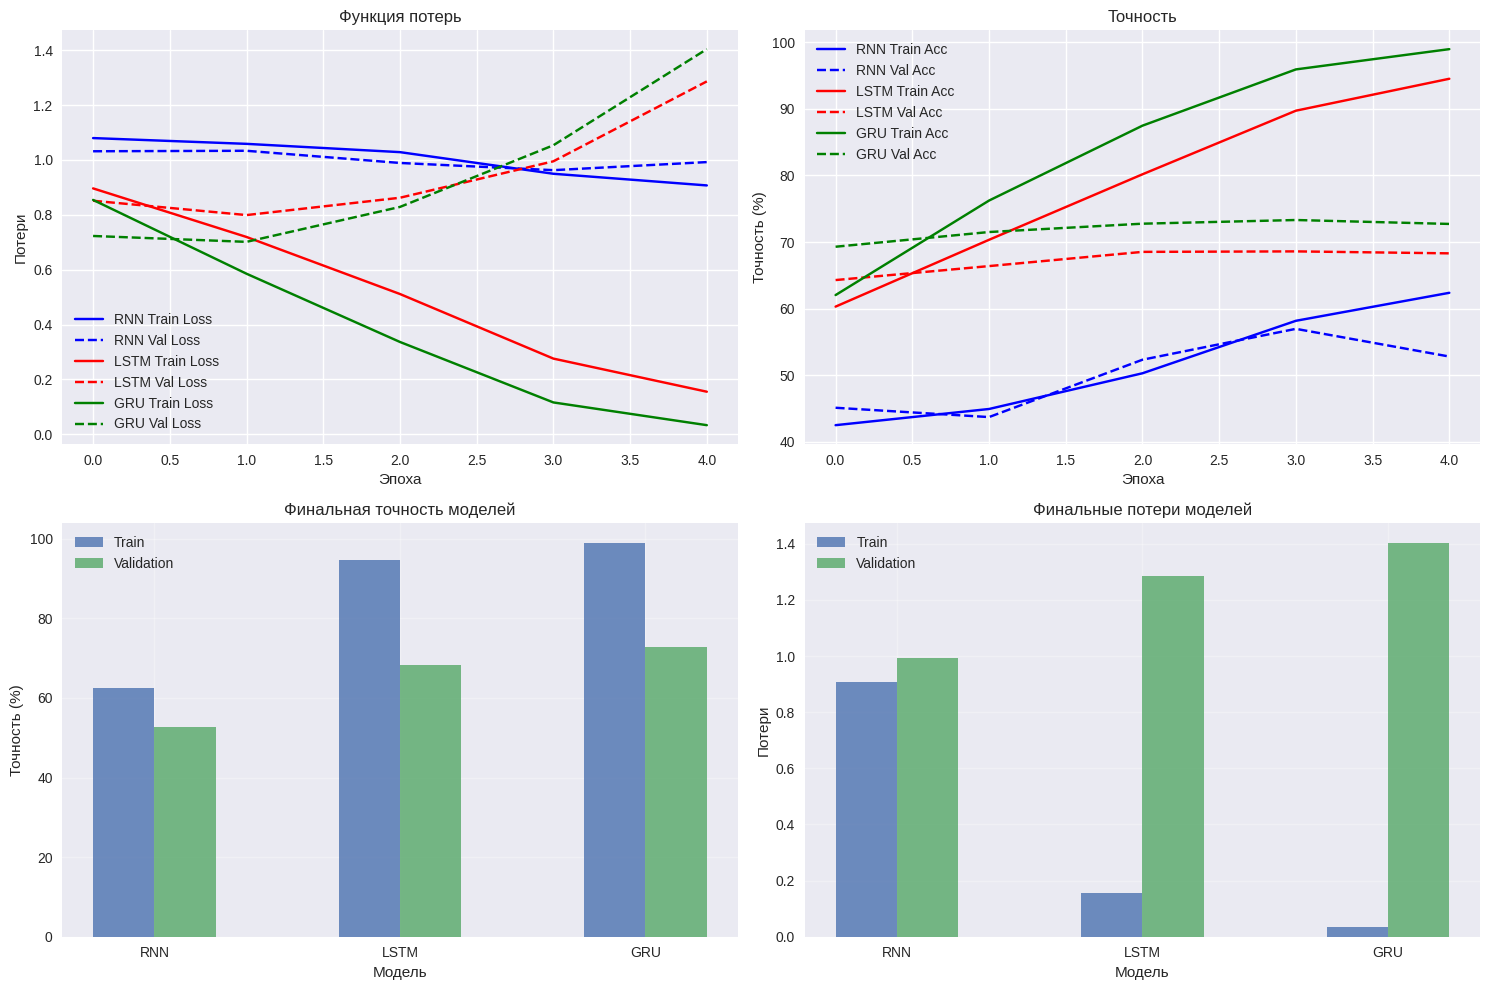


Финальные результаты обучения:
RNN - Train Acc: 62.37%, Val Acc: 52.80%
LSTM - Train Acc: 94.52%, Val Acc: 68.30%
GRU - Train Acc: 98.97%, Val Acc: 72.72%


In [20]:
# Графики обучения
plt.figure(figsize=(15, 10))

# График потерь
plt.subplot(2, 2, 1)
plt.plot(rnn_train_losses, label='RNN Train Loss', color='blue', linestyle='-')
plt.plot(rnn_val_losses, label='RNN Val Loss', color='blue', linestyle='--')
plt.plot(lstm_train_losses, label='LSTM Train Loss', color='red', linestyle='-')
plt.plot(lstm_val_losses, label='LSTM Val Loss', color='red', linestyle='--')
plt.plot(gru_train_losses, label='GRU Train Loss', color='green', linestyle='-')
plt.plot(gru_val_losses, label='GRU Val Loss', color='green', linestyle='--')
plt.title('Функция потерь')
plt.xlabel('Эпоха')
plt.ylabel('Потери')
plt.legend()
plt.grid(True)

# График точности
plt.subplot(2, 2, 2)
plt.plot(rnn_train_accs, label='RNN Train Acc', color='blue', linestyle='-')
plt.plot(rnn_val_accs, label='RNN Val Acc', color='blue', linestyle='--')
plt.plot(lstm_train_accs, label='LSTM Train Acc', color='red', linestyle='-')
plt.plot(lstm_val_accs, label='LSTM Val Acc', color='red', linestyle='--')
plt.plot(gru_train_accs, label='GRU Train Acc', color='green', linestyle='-')
plt.plot(gru_val_accs, label='GRU Val Acc', color='green', linestyle='--')
plt.title('Точность')
plt.xlabel('Эпоха')
plt.ylabel('Точность (%)')
plt.legend()
plt.grid(True)

# Сравнение финальной точности
plt.subplot(2, 2, 3)
models = ['RNN', 'LSTM', 'GRU']
train_final_accs = [rnn_train_accs[-1], lstm_train_accs[-1], gru_train_accs[-1]]
val_final_accs = [rnn_val_accs[-1], lstm_val_accs[-1], gru_val_accs[-1]]

x = np.arange(len(models))
width = 0.25

plt.bar(x - width/2, train_final_accs, width, label='Train', alpha=0.8)
plt.bar(x + width/2, val_final_accs, width, label='Validation', alpha=0.8)
plt.title('Финальная точность моделей')
plt.xlabel('Модель')
plt.ylabel('Точность (%)')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

# Сравнение финальных потерь (включаем GRU)
plt.subplot(2, 2, 4)
train_final_losses = [rnn_train_losses[-1], lstm_train_losses[-1], gru_train_losses[-1]]
val_final_losses = [rnn_val_losses[-1], lstm_val_losses[-1], gru_val_losses[-1]]

plt.bar(x - width/2, train_final_losses, width, label='Train', alpha=0.8)
plt.bar(x + width/2, val_final_losses, width, label='Validation', alpha=0.8)
plt.title('Финальные потери моделей')
plt.xlabel('Модель')
plt.ylabel('Потери')
plt.xticks(x, models)
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nФинальные результаты обучения:")
print(f"RNN - Train Acc: {rnn_train_accs[-1]:.2f}%, Val Acc: {rnn_val_accs[-1]:.2f}%")
print(f"LSTM - Train Acc: {lstm_train_accs[-1]:.2f}%, Val Acc: {lstm_val_accs[-1]:.2f}%")
print(f"GRU - Train Acc: {gru_train_accs[-1]:.2f}%, Val Acc: {gru_val_accs[-1]:.2f}%")


Бутстрэп-оценка accuracy и f1-score, визуализация доверительных интервалов.

Решил сравнить, в целом Модель на основе GRU показала лучшее результаты, хоть не сильно отличающиеся от LSTM

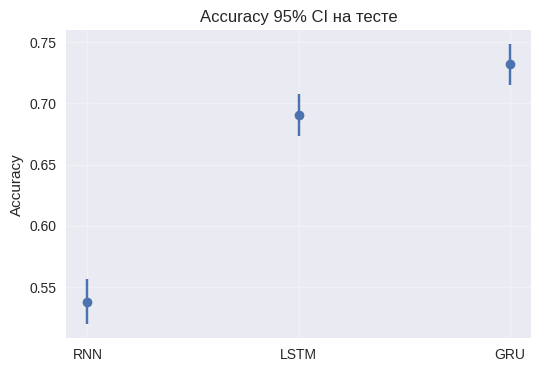

In [21]:
import numpy as np
from sklearn.metrics import f1_score, accuracy_score

# Сбор предсказаний на тесте для каждой модели
rnn_preds, rnn_labels = evaluate_model(rnn_model, test_loader)
lstm_preds, lstm_labels = evaluate_model(lstm_model, test_loader)
gru_preds, gru_labels = evaluate_model(gru_model, test_loader)

rnn_preds = np.array(rnn_preds)
lstm_preds = np.array(lstm_preds)
gru_preds = np.array(gru_preds)
test_labels = np.array(rnn_labels)

def bootstrap_metric(preds, labels, metric_fn, n_boot=2000, seed=42, ci=95):
    rng = np.random.default_rng(seed)
    n = len(labels)
    stats = np.empty(n_boot)
    for i in range(n_boot):
        idx = rng.integers(0, n, n)
        stats[i] = metric_fn(labels[idx], preds[idx])
    lower = np.percentile(stats, (100-ci)/2)
    upper = np.percentile(stats, 100 - (100-ci)/2)
    return stats.mean(), lower, upper, stats

# Метрики для каждой модели
acc_fn = lambda y, p: accuracy_score(y, p)
f1_fn = lambda y, p: f1_score(y, p, average='macro')

n_boot = 2000
ci = 95

rnn_acc_mean, rnn_acc_lo, rnn_acc_hi, rnn_acc_stats = bootstrap_metric(rnn_preds, test_labels, acc_fn, n_boot, seed=1, ci=ci)
lstm_acc_mean, lstm_acc_lo, lstm_acc_hi, lstm_acc_stats = bootstrap_metric(lstm_preds, test_labels, acc_fn, n_boot, seed=2, ci=ci)
gru_acc_mean, gru_acc_lo, gru_acc_hi, gru_acc_stats = bootstrap_metric(gru_preds, test_labels, acc_fn, n_boot, seed=3, ci=ci)

rnn_f1_mean, rnn_f1_lo, rnn_f1_hi, _ = bootstrap_metric(rnn_preds, test_labels, f1_fn, n_boot, seed=4, ci=ci)
lstm_f1_mean, lstm_f1_lo, lstm_f1_hi, _ = bootstrap_metric(lstm_preds, test_labels, f1_fn, n_boot, seed=5, ci=ci)
gru_f1_mean, gru_f1_lo, gru_f1_hi, _ = bootstrap_metric(gru_preds, test_labels, f1_fn, n_boot, seed=6, ci=ci)

# Простой график точек с CI для accuracy
models = ['RNN', 'LSTM', 'GRU']
means = [rnn_acc_mean, lstm_acc_mean, gru_acc_mean]
los = [rnn_acc_mean - rnn_acc_lo, lstm_acc_mean - lstm_acc_lo, gru_acc_mean - gru_acc_lo]
his = [rnn_acc_hi - rnn_acc_mean, lstm_acc_hi - lstm_acc_mean, gru_acc_hi - gru_acc_mean]

plt.figure(figsize=(6,4))
plt.errorbar(models, means, yerr=[los, his], fmt='o', capsize=6)
plt.title(f'Accuracy {ci}% CI на тесте')
plt.ylabel('Accuracy')
plt.grid(alpha=0.3)
plt.show()

# 12. Анализ ошибок GRU

Матрица ошибок, classification report и посмотрим на несколько примеров где ошиблась модель

In [44]:
# GRU результаты
print("GRU Модель:")
print(classification_report(gru_labels, gru_preds,
                          target_names=['negative', 'positive', 'neutral']))

GRU Модель:
              precision    recall  f1-score   support

    negative       0.60      0.50      0.54       434
    positive       0.72      0.80      0.76      1101
     neutral       0.79      0.76      0.77      1182

    accuracy                           0.73      2717
   macro avg       0.70      0.68      0.69      2717
weighted avg       0.73      0.73      0.73      2717

GRU: 0.7321 (73.21%)


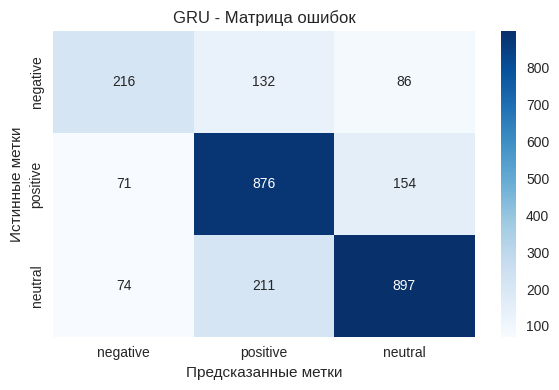

In [46]:
# Матрицы ошибок
plt.figure(figsize=(6,4))
# GRU матрица ошибок
gru_cm = confusion_matrix(gru_labels, gru_preds)
sns.heatmap(gru_cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['negative', 'positive', 'neutral'],
            yticklabels=['negative', 'positive', 'neutral'])
plt.title('GRU - Матрица ошибок')
plt.xlabel('Предсказанные метки')
plt.ylabel('Истинные метки')

plt.tight_layout()
plt.show()

В целом неплохие результаты. Негативный класс меньше всего представлен в корпусе, и даже так модель неплохо определяла этот класс, в отличие от randomforest, из прошлой работы

In [29]:
# Извлечение ошибок
errors = []
for i, (true_label, pred_label, text) in enumerate(zip(gru_labels, gru_preds, test_df['text_clean'])):
    if true_label != pred_label:
        errors.append((true_label, pred_label, text))

label_class = ['negative', 'positive', 'neutral']

# Вывод ошибок
print("Примеры ошибок модели GRU:")
for i, (true_label, pred_label, text) in enumerate(errors[:10]):
    print(f"Текст: {text}")
    print(f"Истинный класс: {label_class[true_label]}")
    print(f"Предсказанный класс: {label_class[pred_label]}")
    print()

Примеры ошибок модели GRU:
Текст: недвижимость цб видит признаки перегрева на рынке ипотеки  обеспокоен качеством кредитов явные недобросовестные практики   набиуллина на рынке ипотеки ушли в прошлое  но есть элементы схемности
Истинный класс: negative
Предсказанный класс: positive

Текст: источники рдв обратили внимание на акции белуги  belu  в конце 2019 года  когда акции стоили около 700 рублей   факты за последние 12 месяцев белуга заплатила 795 рублей дивидендов на акцию  источники рдв   всегда впереди брокеров и банков   ak47pfl
Истинный класс: neutral
Предсказанный класс: positive

Текст: цбрф цб рассматривал повышение ставки  но консенсусом было решение сохранить ставку   набиуллина
Истинный класс: positive
Предсказанный класс: neutral

Текст: прогноз по золоту на ii квартал  еще по  2000 в i квартале 2023 г  цены на золото прибавили 7   котировки дважды прокалывали важную психологическую отметку  2000  но закрепиться выше пока не получилось  динамика цен на золото была довольн

# 13. Тестирование на новых примерах

Проверка работы лучшей модели на новых сгенерированных примерах.

In [42]:
examples = [
    "ЦБ повысил ключевую ставку до 16%.",
    "Акции Газпрома выросли на фоне позитивных новостей.",
    "Рубль резко ослаб на торгах в понедельник.",
    "ВТБ объявил о рекордной прибыли за квартал.",
    "Инвесторы опасаются новых санкций против России."
]
example_labels = ["neutral", "positive", "negative", "positive", "negative"]
label_mapping = {"negative": 0, "neutral": 1, "positive": 2}
new_labels_numeric = [label_mapping[label] for label in example_labels]

# Преобразование в DataLoader
new_dataset = [(label, clean_text(text)) for label, text in zip(new_labels_numeric, examples)]
new_loader = DataLoader(new_dataset, batch_size=1, collate_fn=collate_batch)

ex_preds, _ = evaluate_model(gru_model, new_loader)

for i, pred in enumerate(ex_preds):
    print(f"Текст: {new_dataset[i][1]}")
    print(f"Истинная метка: {example_labels[i]}")
    print(f"Предсказанная метка: {label_class[ex_preds[i]]}\n")

Текст: цб повысил ключевую ставку до 16
Истинная метка: neutral
Предсказанная метка: neutral

Текст: акции газпрома выросли на фоне позитивных новостей
Истинная метка: positive
Предсказанная метка: neutral

Текст: рубль резко ослаб на торгах в понедельник
Истинная метка: negative
Предсказанная метка: positive

Текст: втб объявил о рекордной прибыли за квартал
Истинная метка: positive
Предсказанная метка: positive

Текст: инвесторы опасаются новых санкций против россии
Истинная метка: negative
Предсказанная метка: positive



Модель также плохо опознает негативные новости, так как это самая маленькая группа в датасете